In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import rioxarray as rxr
import rasterio 
import xarray as xr
import earthpy as et
from multiprocessing import Pool
from parallel_xarray import sample_tif
from get_dynamic_by_date import get_date_df
from istarmap import istarmap
import tqdm
import pandas as pd 
import elevation
import richdem as rd
from shapely import geometry
import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from dask import dataframe as dd
import dask_ml
import joblib
from sklearn.utils import parallel_backend
import pickle
import datetime as dt

In [10]:
# pull csv of latitude logitude coordinates of points 
# turkana
tur_path = 'F:\\Tara_Fall_2019\\Kenya_Drought\\reference_spatial_files\\turkana_fishnet.csv'
tur_pts = pd.read_csv(tur_path)

tur_lats = list(tur_pts.lat)
tur_lons = list(tur_pts.lon)

# narok 
nar_path = 'F:\\Tara_Fall_2019\\Kenya_Drought\\reference_spatial_files\\narok_fishnet.csv'
nar_pts = pd.read_csv(nar_path)

nar_lats = list(nar_pts.lat)
nar_lons = list(nar_pts.lon)

In [2]:
# import parquet files into dask dataframes to make for easier processing 
# lulc = [1,2,3,4]
# lulc_strings = ["tree", "shrub", "grass", "crop"]

# turkana files
tur_path = 'F:\\Tara_Fall_2019\\Kenya_Drought\\reference_spatial_files\\turkana_parquet'
tur_files = [os.path.join(tur_path, file) for file in os.listdir(tur_path) if '_all' in file]
turkana = dd.read_parquet(tur_files) 
# narok files 
nar_path = 'F:\\Tara_Fall_2019\\Kenya_Drought\\reference_spatial_files\\narok_parquet'
nar_files = [os.path.join(nar_path, file) for file in os.listdir(nar_path) if '_all' in file]
narok = dd.read_parquet(nar_files)

In [3]:
# subset by LULC for turkana and narok data -  one new dask dataframe for each land use type 
turkana_lulc = []
narok_lulc = []
for l in [1,2,3,4]: 
    turkana_lulc.append(turkana[turkana.lulc == l])
    narok_lulc.append(narok[narok.lulc == l])

In [4]:
# import model pickles 
tur_pckl = ["tur_tree.pkl", "tur_shrub.pkl", "tur_grass.pkl", "tur_crop.pkl"]
nar_pckl = ["nar_tree.pkl", "nar_shrub.pkl", "nar_grass.pkl", "nar_crop.pkl"]
# save models once read
tur_models = []
nar_models = []
for i in range(4): 
    with open(nar_pckl[i],'rb') as f:
        model = pickle.load(f)
        nar_models.append(model)
    with open(tur_pckl[i],'rb') as f:
        model = pickle.load(f)
        tur_models.append(model)

In [6]:
# create year and month columns 
turkana["year"] = turkana.date.dt.year
turkana["month"] = turkana.date.dt.month

narok["year"] = narok.date.dt.year
narok["month"] = narok.date.dt.month

In [38]:
narok.head()

,lat,lon,date,SAVI_zscore,16_day_sum_ppt,32_day_sum_ppt,48_day_sum_ppt,64_day_sum_ppt,16_day_mean_ppt,32_day_mean_ppt,...,slope,elevation,bdod0_200cm_mean,cfvo0_200cm_mean,clay0_200cm_mean,sand0_200cm_mean,silt0_200cm_mean,soc0_200cm_mean,year,month
0,-1.307511,34.711601,2018-05-12,1.068818,4.087348,9.907214,15.796621,21.326906,0.255459,0.309600,...,3.004626,1702.0,126.400,116.325,496.850,285.300,217.650,129.875,2018,5
0,-2.081963,35.966996,2020-10-24,1.674183,0.708483,0.825641,0.870507,2.065770,0.044280,0.025801,...,10.622957,693.0,138.325,212.675,318.400,478.250,203.175,58.950,2020,10
0,-1.280568,34.983341,2020-12-11,1.002483,3.927088,7.918962,12.548854,16.782640,0.245443,0.247468,...,4.487637,1591.0,132.975,123.275,425.550,392.675,181.725,94.200,2020,12
0,-1.197494,35.958013,2016-05-22,-1.572131,2.412561,6.611522,9.152613,10.722915,0.150785,0.206610,...,10.069205,1827.0,128.125,159.875,371.625,364.775,263.450,77.150,2016,5
0,-1.693653,35.951276,2016-11-30,-0.088681,3.009835,4.367956,4.893581,6.014022,0.188115,0.136499,...,6.588078,1755.0,127.900,116.300,410.025,396.250,193.875,126.225,2016,11


In [73]:
narok_mean = narok.groupby(["FID"]).mean().compute()

In [107]:
grouped_nar = narok.groupby(["year", "month", "FID"]).mean().compute()

In [108]:
grouped_nar = grouped_nar.reset_index()

In [109]:
feb_15 = grouped_nar[(grouped_nar.year == 2015) & (grouped_nar.month == 9)]
feb_16 = grouped_nar[(grouped_nar.year == 2016) & (grouped_nar.month == 9)]
feb_17 = grouped_nar[(grouped_nar.year == 2017) & (grouped_nar.month == 9)]
feb_18 = grouped_nar[(grouped_nar.year == 2018) & (grouped_nar.month == 9)]
feb_19 = grouped_nar[(grouped_nar.year == 2019) & (grouped_nar.month == 9)]
feb_20 = grouped_nar[(grouped_nar.year == 2020) & (grouped_nar.month == 9)]

### plot maps of SAVI z score 

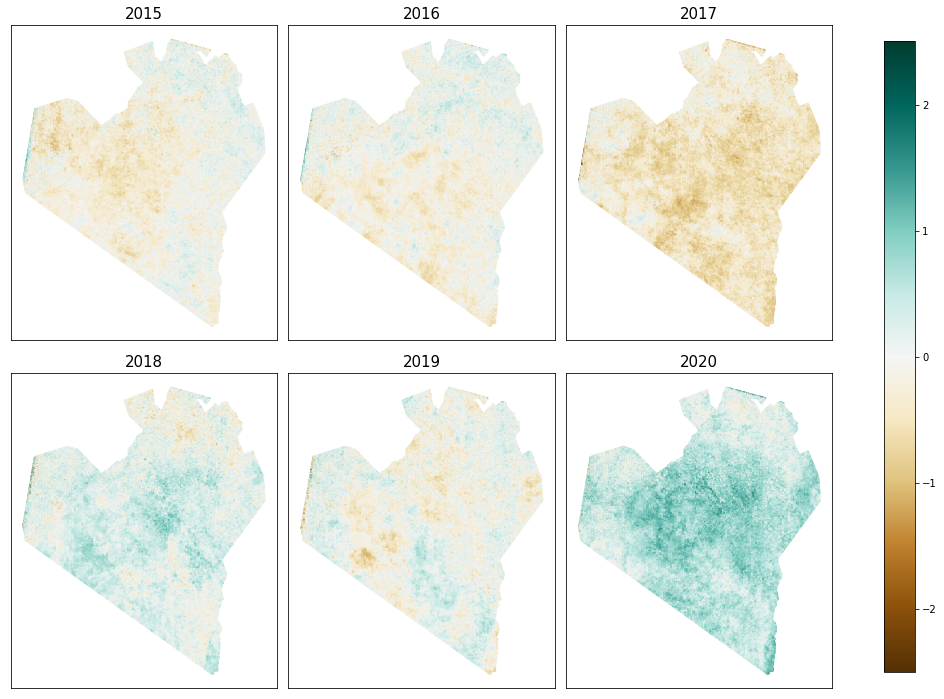

In [106]:
fig, axs = plt.subplots(nrows = 2, ncols = 3, sharex = True, sharey = True, figsize = (15, 10))
axs[0][0].scatter(feb_15.lon, feb_15.lat, c = feb_15.SAVI_zscore, cmap = 'BrBG', vmin = -2.5, vmax = 2.5, s = .1)
axs[0][1].scatter(feb_16.lon, feb_16.lat, c = feb_16.SAVI_zscore, cmap = 'BrBG', vmin = -2.5, vmax = 2.5, s = .1)
axs[0][2].scatter(feb_17.lon, feb_17.lat, c = feb_17.SAVI_zscore, cmap = 'BrBG', vmin = -2.5, vmax = 2.5, s = .1)
axs[0][0].set_title("2015", fontsize = 15)
axs[0][1].set_title("2016", fontsize = 15)
axs[0][2].set_title("2017", fontsize = 15)

axs[1][0].scatter(feb_18.lon, feb_18.lat, c = feb_18.SAVI_zscore, cmap = 'BrBG', vmin = -2.5, vmax = 2.5, s = .1)
axs[1][1].scatter(feb_19.lon, feb_19.lat, c = feb_19.SAVI_zscore, cmap = 'BrBG', vmin = -2.5, vmax = 2.5, s = .1)
im = axs[1][2].scatter(feb_20.lon, feb_20.lat, c = feb_20.SAVI_zscore, cmap = 'BrBG', vmin = -2.5, vmax = 2.5, s = .1)
axs[1][0].set_title("2018", fontsize = 15)
axs[1][1].set_title("2019", fontsize = 15)
axs[1][2].set_title("2020", fontsize = 15)

# plt.suptitle("SAVI z-score - Narok", fontsize = 20)
plt.tight_layout()
for ax in axs.reshape(-1):
    ax.set_xticks([])
    ax.set_yticks([])

cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.95)
# cbar.set_ticks(np.arange(0, 1.1, 0.5))
# cbar.set_ticklabels(['low', 'medium', 'high'])

plt.savefig("F:\\Tara_Fall_2019\\Kenya_Drought\\Figures\\Narok_annual_SAVI_zscore.jpg")

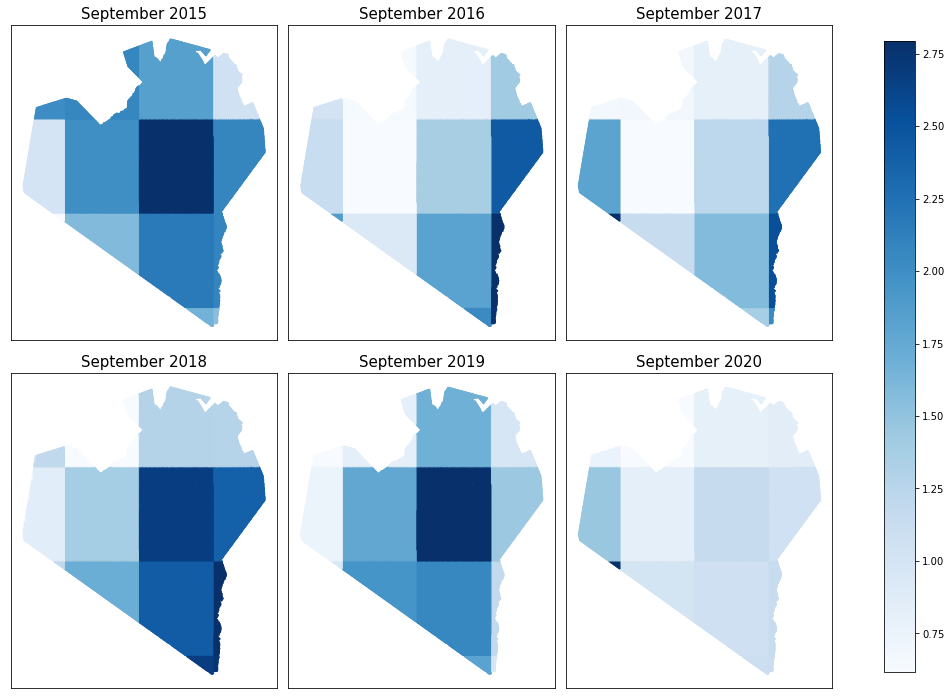

In [110]:
fig, axs = plt.subplots(nrows = 2, ncols = 3, sharex = True, sharey = True, figsize = (15, 10))
axs[0][0].scatter(feb_15.lon, feb_15.lat, c = feb_15["64_day_stdv_temp"], cmap = 'Blues', s = .1)
axs[0][1].scatter(feb_16.lon, feb_16.lat, c = feb_16["64_day_stdv_temp"], cmap = 'Blues', s = .1)
axs[0][2].scatter(feb_17.lon, feb_17.lat, c = feb_17["64_day_stdv_temp"], cmap = 'Blues', s = .1)
axs[0][0].set_title("September 2015", fontsize = 15)
axs[0][1].set_title("September 2016", fontsize = 15)
axs[0][2].set_title("September 2017", fontsize = 15)

axs[1][0].scatter(feb_18.lon, feb_18.lat, c = feb_18["64_day_stdv_temp"], cmap = 'Blues', s = .1)
axs[1][1].scatter(feb_19.lon, feb_19.lat, c = feb_19["64_day_stdv_temp"], cmap = 'Blues', s = .1)
im = axs[1][2].scatter(feb_20.lon, feb_20.lat, c = feb_20["64_day_stdv_temp"], cmap = 'Blues', s = .1)
axs[1][0].set_title("September 2018", fontsize = 15)
axs[1][1].set_title("September 2019", fontsize = 15)
axs[1][2].set_title("September 2020", fontsize = 15)

# plt.suptitle("SAVI z-score - Narok", fontsize = 20)
plt.tight_layout()
for ax in axs.reshape(-1):
    ax.set_xticks([])
    ax.set_yticks([])

cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.95)
# cbar.set_ticks(np.arange(0, 1.1, 0.5))
# cbar.set_ticklabels(['low', 'medium', 'high'])

# plt.savefig("F:\\Tara_Fall_2019\\Kenya_Drought\\Figures\\Narok_feb_SAVI_zscore.jpg")

### plot time series of SAVI z score information 

In [121]:
# group by month and year to plot averaged tie series for each region 
grouped_turk = turkana.groupby(["year", "month", "lulc"]).std().compute()
grouped_nar = narok.groupby(["year", "month", "lulc"]).std().compute()

In [122]:
# reset index 
grouped_turk.reset_index(inplace = True)
grouped_nar.reset_index(inplace = True)

In [123]:
# for smoothing 
grouped_turk['mov_avg'] = grouped_turk['SAVI_zscore'].rolling(6).mean()
# for smoothing 
grouped_nar['mov_avg'] = grouped_nar['SAVI_zscore'].rolling(6).mean()

In [124]:
# plot time series 
df = grouped_nar
savi_ts_x_lulc_nar = []
for lulc in [1,2,3,4]:
    savi_ts = df[df.lulc == lulc].mov_avg.to_list()
    savi_ts_x_lulc_nar.append(savi_ts)
    
time_list = list(zip(df[df.lulc == 1].year.to_list(), df[df.lulc == 1].month.to_list(), [1]*len(df[df.lulc == 1].month.to_list())))
nar_dtlist = [datetime.datetime(*t) for t in time_list]
    
df = grouped_turk
savi_ts_x_lulc_turk = []
for lulc in [1,2,3,4]:
    savi_ts = df[df.lulc == lulc].mov_avg.to_list()
    savi_ts_x_lulc_turk.append(savi_ts)
    
time_list = list(zip(df[df.lulc == 1].year.to_list(), df[df.lulc == 1].month.to_list(), [1]*len(df[df.lulc == 1].month.to_list())))
tur_dtlist = [datetime.datetime(*t) for t in time_list]

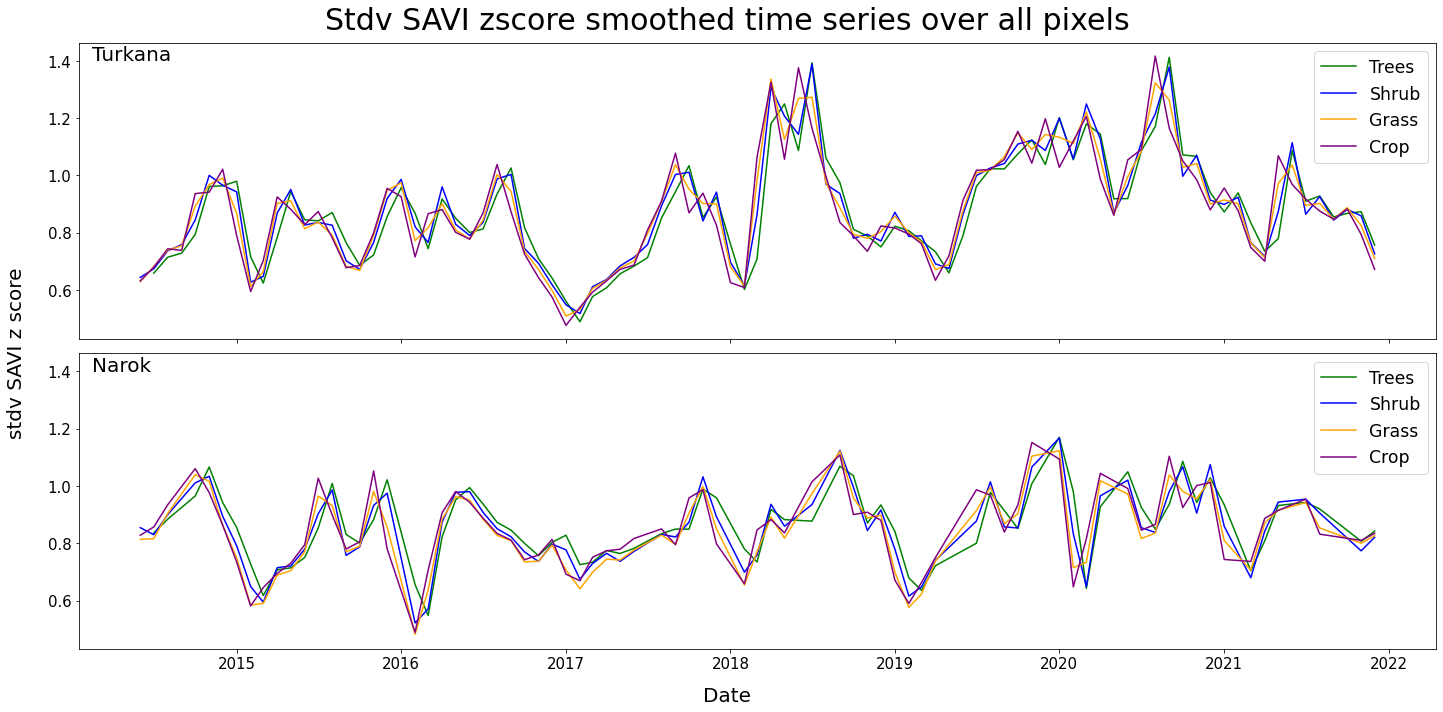

In [126]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, sharex = True, sharey = True, figsize = (20, 10))
axs[0].text(0.01, .99, "Turkana", ha="left", va="top", transform=axs[0].transAxes, fontsize = 20)
axs[0].plot(tur_dtlist, savi_ts_x_lulc_turk[0], color = "green", label = "Trees")
axs[0].plot(tur_dtlist, savi_ts_x_lulc_turk[1], color = "blue", label = "Shrub")
axs[0].plot(tur_dtlist, savi_ts_x_lulc_turk[2], color = "orange", label = "Grass")
axs[0].plot(tur_dtlist, savi_ts_x_lulc_turk[3], color = "purple", label = "Crop")
axs[0].legend(fontsize = 'xx-large')
axs[0].tick_params(axis='both', which='major', labelsize=15)

axs[1].text(0.01, .99, "Narok", ha="left", va="top", transform=axs[1].transAxes, fontsize = 20)
axs[1].plot(nar_dtlist, savi_ts_x_lulc_nar[0], color = "green", label = "Trees")
axs[1].plot(nar_dtlist, savi_ts_x_lulc_nar[1], color = "blue", label = "Shrub")
axs[1].plot(nar_dtlist, savi_ts_x_lulc_nar[2], color = "orange", label = "Grass")
axs[1].plot(nar_dtlist, savi_ts_x_lulc_nar[3], color = "purple", label = "Crop")
axs[1].legend(fontsize = 'xx-large')
axs[1].tick_params(axis='both', which='major', labelsize=15)


fig.supxlabel("Date", fontsize = 20)
fig.supylabel("stdv SAVI z score", x = 0, fontsize = 20)
fig.suptitle("Stdv SAVI zscore smoothed time series over all pixels", fontsize = 30)
# fig.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()
plt.savefig("F:\\Tara_Fall_2019\\Kenya_Drought\\Figures\\SAVIzscore_stdv_x_lulc_6mosmooth.jpg")

In [8]:
# pull a specific FID
fid = turkana[turkana.FID == 724625].compute()
# get a specific month in the record of that FID
jun = fid[fid.date.dt.month == 6]
# sort by the date 
sort_df = fid.sort_values("date")

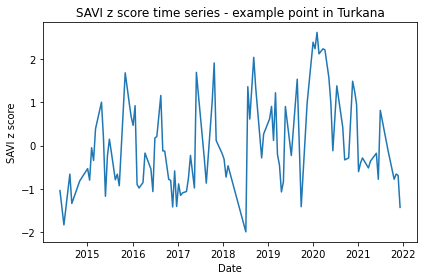

In [19]:
# example plots for scatter of 
plt.plot(sort_df.date, sort_df.SAVI_zscore)
plt.title("SAVI z score time series - example point in Turkana")
plt.xlabel("Date")
# plt.scatter(fid["64_day_sum_ppt"], fid.SAVI_zscore)
# plt.title("SAVI zscore vs 64-day cumulative precip - example point in Turkana")
# plt.xlabel("64 day cumulative precip prior to SAVI measurement")
plt.ylabel("SAVI z score")
plt.tight_layout()
plt.savefig("F:\\Tara_Fall_2019\\Kenya_Drought\\Figures\\SAVIzscore_ts_example.jpg")
# plt.savefig("F:\\Tara_Fall_2019\\Kenya_Drought\\Figures\\SAVIzscore_vs_64ppt_example.jpg")

In [69]:
# fig, axs = plt.subplots(nrows = 2, ncols = 4, sharex = True, sharey = True, figsize = (30,15))
# fig.suptitle("Turkana Annual SAVI z-score histograms")
# for yr, savi, ax in zip(yrs, savi_x_yr, axs.ravel()):
#     ax.hist(savi, bins = 20)
#     ax.set_title(str(yr))


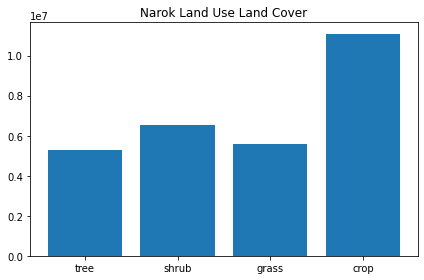

In [24]:
# bar chart of lulc for each region
df = narok
lulc = df.lulc.value_counts().compute()

lulc_labels = ["tree", "shrub", "grass", "crop"]
x = lulc.index.to_list()
height = lulc.to_list()
plt.bar(x, height, tick_label = [lulc_labels[int(i-1)] for i in x])
plt.title("Narok Land Use Land Cover")
plt.tight_layout()
plt.savefig("F:\\Tara_Fall_2019\\Kenya_Drought\\Figures\\Narok_lulc_bar.jpg")